# Leveraging Location Data to Predict COVID19 Hotspots in Neighbourhoods

## Importing relevant modules


In [86]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [18]:
#Using FourSquare API

CLIENT_ID = '0YCTX5BYNJG3RGGJ25FXEFUO3Y1BQAMX1JW0JOICWP3YTQGS' # your Foursquare ID
CLIENT_SECRET = '22TCPZACVWLQE0ZOAHCL5UHZ1EFB2BXAJTZIZSXWYZRWOWOU' # your Foursquare Secret
ACCESS_TOKEN = 'YN0HOBUH3ZFMH1PVDENGQ20WMFUWMWDEHYPAXXYLQLIQAYPO' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 3000
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 0YCTX5BYNJG3RGGJ25FXEFUO3Y1BQAMX1JW0JOICWP3YTQGS
CLIENT_SECRET:22TCPZACVWLQE0ZOAHCL5UHZ1EFB2BXAJTZIZSXWYZRWOWOU


In [28]:
#Defining a location 
address = 'Christchurch, NZ'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-43.530955 172.6366455


## Now we need to obtain a matrix of the various businesses and their associated risk factors
### Firstly, we have to determine a dataset of the various services within a certain neighbourhood.

In [94]:
riskdf = pd.read_csv(r'C:\Users\shaik\Downloads\Risk Factors.csv')
riskdf.rename(columns={'Category ID': 'categories'}, inplace=True)


In [60]:
#Obtaining a datafrome of all nearby businesses within Pasir Ris Neighbourhood of radius 2000m

search_query = ""
radius = 5000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.head()


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4fa09e31e4b0e43340e2449a,Christchurch Cathedral Ruins,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",v-1624982482,False,Worcester St,-43.530746,172.636356,"[{'label': 'display', 'lat': -43.5307457705623...",33,8011,NZ,Christchurch,Canterbury,New Zealand,"[Worcester St, Christchurch 8011, New Zealand]",NaN,NaN
1,4c7098f59375a0930bc00737,Christchurch Tramway,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...",v-1624982482,False,"7 Tramway Ln, Christchurch Central",-43.530874,172.635702,"[{'label': 'display', 'lat': -43.5308743093562...",76,8011,NZ,Christchurch,Canterbury,New Zealand,"[7 Tramway Ln, Christchurch Central, Christchu...",NaN,NaN
2,50dfccc2e4b0c970853845cd,Cathedral Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1624982482,False,Worcester St,-43.530868,172.636219,"[{'label': 'display', 'lat': -43.5308679350523...",35,NaN,NZ,Christchurch,Canterbury,New Zealand,"[Worcester St (at Colombo St.), Christchurch, ...",at Colombo St.,NaN
3,4b553321f964a52069de27e3,Bailies Bar & Restaurant,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1624982482,False,1066 Colombo St,-43.530731,172.636620,"[{'label': 'display', 'lat': -43.5307306576343...",25,NaN,NZ,Christchurch,Canterbury,New Zealand,"[1066 Colombo St (Edgeware Rd), St. Albans, Ne...",Edgeware Rd,NaN
4,52b11d76498e401614ccb100,Rollickin' Gelato,"[{'id': '5f2c407c5b4c177b9a6dc536', 'name': 'G...",v-1624982482,False,35 New Regent Street,-43.529030,172.638722,"[{'label': 'display', 'lat': -43.5290299074921...",272,8011,NZ,NaN,NaN,New Zealand,"[35 New Regent Street, 8011, New Zealand]",NaN,NaN


In [66]:
header = np.asarray(dataframe.columns)
#['name','categories','location.address', 'location.lat','location.lng']
index = [1,2,5,6,7]
header = np.delete(header,index)
dataframe2 = dataframe.drop(columns = header, axis =1 )


,name,categories,location.address,location.lat,location.lng
0,Christchurch Cathedral Ruins,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",Worcester St,-43.530746,172.636356
1,Christchurch Tramway,"[{'id': '4bf58dd8d48988d1fc931735', 'name': 'L...","7 Tramway Ln, Christchurch Central",-43.530874,172.635702
2,Cathedral Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",Worcester St,-43.530868,172.636219
3,Bailies Bar & Restaurant,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",1066 Colombo St,-43.530731,172.636620
4,Rollickin' Gelato,"[{'id': '5f2c407c5b4c177b9a6dc536', 'name': 'G...",35 New Regent Street,-43.529030,172.638722


### Generating a map for plotting businesses within Christchurch

In [69]:
# create map of Toronto using latitude and longitude values
map_cc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, categories in zip(dataframe2['location.lat'], dataframe2['location.lng'], dataframe2['name'], dataframe2['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cc)  
map_cc  

### Using k-Means to cluster data points


In [79]:
#Setting up latitude and Longitude


X = dataframe2[['location.lat','location.lng']].to_numpy()


In [81]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)

In [82]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [83]:
k_means_labels = k_means.labels_
k_means_labels

array([2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 1, 2, 2, 0, 1,
       2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3])

In [84]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[-43.53017046, 172.63723838],
       [-43.53205751, 172.63688456],
       [-43.53116582, 172.63568297],
       [-43.53692204, 172.63936299]])

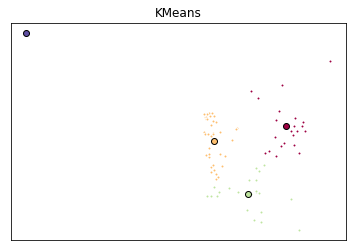

In [87]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()


In [88]:
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)

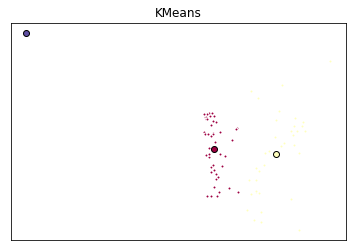

In [89]:
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

### As can be seen, a K means of 3 cluster makes the most sense in detecting the hostpots of the distribution of frequently visited places within Christchurch

In [90]:
k_means_cluster_centers

array([[-43.53203702, 172.63672237],
       [-43.53043298, 172.63659966],
       [-43.53692204, 172.63936299]])

In [93]:
#Thus plotting this into the map of Christchurch:
for lat, lng, in zip(k_means_cluster_centers[0], k_means_cluster_centers[1]):
    folium.CircleMarker(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=True,
        fill_color='',
        fill_opacity=1,
        parse_html=False).add_to(map_cc)  
map_cc  